# Customer Churn Prediction - Feature Engineering

This notebook implements feature engineering techniques to create predictive variables for the customer churn prediction model.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Create directories for saving outputs
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../models', exist_ok=True)

## 1. Load the Cleaned Data

In [2]:
# Load the cleaned data
df_cleaned = pd.read_csv('../data/cleaned/churn_cleaned.csv')

# Display basic information
print(f"Dataset shape: {df_cleaned.shape}")
print(f"\nColumns: {df_cleaned.columns.tolist()}")
print(f"\nSample data:")
df_cleaned.head()

Dataset shape: (10000, 11)

Columns: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

Sample data:


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2,0.00,1.0,1,1,101348.88,1
1,608.0,Spain,Female,41.0,1,83807.86,1.0,0,1,112542.58,0
2,502.0,France,Female,42.0,8,159660.80,3.0,1,0,113931.57,1
3,699.0,France,Female,39.0,1,0.00,2.0,0,0,93826.63,0
4,850.0,Spain,Female,43.0,2,125510.82,1.0,1,1,79084.10,0


## 2. Create Base Features

In [3]:
# Create a copy of the dataframe for feature engineering
df_engineered = df_cleaned.copy()

# One-hot encode categorical variables
df_engineered = pd.get_dummies(df_engineered, columns=['Geography', 'Gender'], drop_first=False)

## 3. Create Age-related Features

In [4]:
# Create age-related features
df_engineered['AgeGroup'] = pd.cut(df_engineered['Age'], bins=[0, 30, 40, 50, 60, 100], labels=[0, 1, 2, 3, 4]).astype(int)
df_engineered['IsYoung'] = (df_engineered['Age'] < 30).astype(int)
df_engineered['IsMiddleAged'] = ((df_engineered['Age'] >= 30) & (df_engineered['Age'] < 50)).astype(int)
df_engineered['IsSenior'] = (df_engineered['Age'] >= 50).astype(int)
df_engineered['IsRetirementAge'] = (df_engineered['Age'] >= 65).astype(int)

# Display the new features
age_features = ['Age', 'AgeGroup', 'IsYoung', 'IsMiddleAged', 'IsSenior', 'IsRetirementAge']
df_engineered[age_features].head(10)

,Age,AgeGroup,IsYoung,IsMiddleAged,IsSenior,IsRetirementAge
0,42.0,2,0,1,0,0
1,41.0,2,0,1,0,0
2,42.0,2,0,1,0,0
3,39.0,1,0,1,0,0
4,43.0,2,0,1,0,0
5,44.0,2,0,1,0,0
6,50.0,2,0,0,1,0
7,29.0,0,1,0,0,0
8,44.0,2,0,1,0,0
9,27.0,0,1,0,0,0


## 4. Create Geography-related Features

In [5]:
# Create geography-related features
df_engineered['GermanyXAge'] = df_engineered['Geography_Germany'] * df_engineered['Age']
df_engineered['GermanyXBalance'] = df_engineered['Geography_Germany'] * df_engineered['Balance']
df_engineered['GermanyXSenior'] = df_engineered['Geography_Germany'] * df_engineered['IsSenior']

# Display the new features
geography_features = ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'GermanyXAge', 'GermanyXBalance', 'GermanyXSenior']
df_engineered[geography_features].head(10)

,Geography_France,Geography_Germany,Geography_Spain,GermanyXAge,GermanyXBalance,GermanyXSenior
0,True,False,False,0.0,0.00,0
1,False,False,True,0.0,0.00,0
2,True,False,False,0.0,0.00,0
3,True,False,False,0.0,0.00,0
4,False,False,True,0.0,0.00,0
5,False,False,True,0.0,0.00,0
6,True,False,False,0.0,0.00,0
7,False,True,False,29.0,115046.74,0
8,True,False,False,0.0,0.00,0
9,True,False,False,0.0,0.00,0


## 5. Create Balance-related Features

In [6]:
# Create balance-related features
df_engineered['HasZeroBalance'] = (df_engineered['Balance'] == 0).astype(int)
df_engineered['BalanceToSalaryRatio'] = df_engineered['Balance'] / (df_engineered['EstimatedSalary'] + 1)  # Add 1 to avoid division by zero
high_balance_threshold = 100000  # This is an approximation, should be based on domain knowledge
df_engineered['HasHighBalance'] = (df_engineered['Balance'] > high_balance_threshold).astype(int)

# Display the new features
balance_features = ['Balance', 'HasZeroBalance', 'BalanceToSalaryRatio', 'HasHighBalance']
df_engineered[balance_features].head(10)

,Balance,HasZeroBalance,BalanceToSalaryRatio,HasHighBalance
0,0.00,1,0.000000,0
1,83807.86,0,0.744670,0
2,159660.80,0,1.401362,1
3,0.00,1,0.000000,0
4,125510.82,0,1.587035,1
5,113755.78,0,0.759599,1
6,0.00,1,0.000000,0
7,115046.74,0,0.963961,1
8,142051.07,0,1.895493,1
9,134603.88,0,1.876621,1


## 6. Create Product-related Features

In [7]:
# Create product-related features
df_engineered['HasMultipleProducts'] = (df_engineered['NumOfProducts'] > 1).astype(int)
df_engineered['HasManyProducts'] = (df_engineered['NumOfProducts'] >= 3).astype(int)
df_engineered['ProductsXAge'] = df_engineered['NumOfProducts'] * df_engineered['Age']
df_engineered['ProductsXBalance'] = df_engineered['NumOfProducts'] * df_engineered['Balance']
df_engineered['ProductsXTenure'] = df_engineered['NumOfProducts'] * df_engineered['Tenure']

# Display the new features
product_features = ['NumOfProducts', 'HasMultipleProducts', 'HasManyProducts', 'ProductsXAge', 'ProductsXBalance', 'ProductsXTenure']
df_engineered[product_features].head(10)

,NumOfProducts,HasMultipleProducts,HasManyProducts,ProductsXAge,ProductsXBalance,ProductsXTenure
0,1.0,0,0,42.0,0.00,2.0
1,1.0,0,0,41.0,83807.86,1.0
2,3.0,1,1,126.0,478982.40,24.0
3,2.0,1,0,78.0,0.00,2.0
4,1.0,0,0,43.0,125510.82,2.0
5,2.0,1,0,88.0,227511.56,16.0
6,2.0,1,0,100.0,0.00,14.0
7,3.5,1,1,101.5,402663.59,14.0
8,2.0,1,0,88.0,284102.14,8.0
9,1.0,0,0,27.0,134603.88,2.0


## 7. Create Tenure-related Features

In [8]:
# Create tenure-related features
df_engineered['IsNewCustomer'] = (df_engineered['Tenure'] <= 1).astype(int)
df_engineered['IsLongTermCustomer'] = (df_engineered['Tenure'] >= 8).astype(int)
df_engineered['TenureSquared'] = df_engineered['Tenure'] ** 2
df_engineered['CustomerValue'] = df_engineered['Tenure'] * df_engineered['Balance'] / 1000  # Scaled for better interpretability

# Display the new features
tenure_features = ['Tenure', 'IsNewCustomer', 'IsLongTermCustomer', 'TenureSquared', 'CustomerValue']
df_engineered[tenure_features].head(10)

,Tenure,IsNewCustomer,IsLongTermCustomer,TenureSquared,CustomerValue
0,2,0,0,4,0.00000
1,1,1,0,1,83.80786
2,8,0,1,64,1277.28640
3,1,1,0,1,0.00000
4,2,0,0,4,251.02164
5,8,0,1,64,910.04624
6,7,0,0,49,0.00000
7,4,0,0,16,460.18696
8,4,0,0,16,568.20428
9,2,0,0,4,269.20776


## 8. Create Engagement-related Features

In [9]:
# Create engagement-related features
df_engineered['EngagementScore'] = df_engineered['IsActiveMember'] * 0.5 + df_engineered['HasCrCard'] * 0.3 + (df_engineered['NumOfProducts'] / 4) * 0.2
df_engineered['ActiveXTenure'] = df_engineered['IsActiveMember'] * df_engineered['Tenure']
df_engineered['ActiveXProducts'] = df_engineered['IsActiveMember'] * df_engineered['NumOfProducts']
df_engineered['ActiveXAge'] = df_engineered['IsActiveMember'] * df_engineered['Age']
df_engineered['InactiveSenior'] = ((df_engineered['IsActiveMember'] == 0) & (df_engineered['IsSenior'] == 1)).astype(int)

# Display the new features
engagement_features = ['IsActiveMember', 'HasCrCard', 'EngagementScore', 'ActiveXTenure', 'ActiveXProducts', 'ActiveXAge', 'InactiveSenior']
df_engineered[engagement_features].head(10)

,IsActiveMember,HasCrCard,EngagementScore,ActiveXTenure,ActiveXProducts,ActiveXAge,InactiveSenior
0,1,1,0.850,2,1.0,42.0,0
1,1,0,0.550,1,1.0,41.0,0
2,0,1,0.450,0,0.0,0.0,0
3,0,0,0.100,0,0.0,0.0,0
4,1,1,0.850,2,1.0,43.0,0
5,0,1,0.400,0,0.0,0.0,0
6,1,1,0.900,7,2.0,50.0,0
7,0,1,0.475,0,0.0,0.0,0
8,1,0,0.600,4,2.0,44.0,0
9,1,1,0.850,2,1.0,27.0,0


## 9. Create Risk Score Features

In [10]:
# Create risk score features based on EDA insights
df_engineered['ChurnRiskScore'] = (
    df_engineered['IsSenior'] * 0.25 + 
    df_engineered['Geography_Germany'] * 0.20 + 
    (1 - df_engineered['IsActiveMember']) * 0.25 + 
    df_engineered['HasManyProducts'] * 0.20 + 
    (df_engineered['Gender_Male'] == 0).astype(int) * 0.10
)

df_engineered['DemographicRiskScore'] = (
    df_engineered['IsSenior'] * 0.4 + 
    df_engineered['Geography_Germany'] * 0.4 + 
    (df_engineered['Gender_Male'] == 0).astype(int) * 0.2
)

df_engineered['ProductRiskScore'] = (
    df_engineered['HasManyProducts'] * 0.5 + 
    (1 - df_engineered['IsActiveMember']) * 0.3 + 
    (1 - df_engineered['HasCrCard']) * 0.2
)

# Display the new features
risk_features = ['ChurnRiskScore', 'DemographicRiskScore', 'ProductRiskScore']
df_engineered[risk_features].head(10)

,ChurnRiskScore,DemographicRiskScore,ProductRiskScore
0,0.10,0.2,0.0
1,0.10,0.2,0.2
2,0.55,0.2,0.8
3,0.35,0.2,0.5
4,0.10,0.2,0.0
5,0.25,0.0,0.3
6,0.25,0.4,0.0
7,0.75,0.6,0.8
8,0.00,0.0,0.2
9,0.00,0.0,0.0


## 10. Feature Scaling

In [11]:
# Identify numerical features that need scaling
numerical_features_to_scale = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary',
    'BalanceToSalaryRatio', 'ProductsXAge', 'ProductsXBalance', 'ProductsXTenure',
    'TenureSquared', 'CustomerValue', 'GermanyXAge', 'GermanyXBalance'
]

# Create a copy of the dataframe for scaled features
df_scaled = df_engineered.copy()

# Apply standard scaling to numerical features
scaler = StandardScaler()
df_scaled[numerical_features_to_scale] = scaler.fit_transform(df_scaled[numerical_features_to_scale])

# Display the scaled features
df_scaled[numerical_features_to_scale].head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,BalanceToSalaryRatio,ProductsXAge,ProductsXBalance,ProductsXTenure,TenureSquared,CustomerValue,GermanyXAge,GermanyXBalance
0,-0.326878,0.342615,-1.041760,-1.225848,0.021886,-0.037882,-0.618396,-1.029796,-1.026752,-0.980675,-0.901822,-0.556262,-0.560017
1,-0.440804,0.240011,-1.387538,0.117350,0.216534,-0.030439,-0.655121,-0.213432,-1.207604,-1.080431,-0.703552,-0.556262,-0.560017
2,-1.538636,0.342615,1.032908,1.333053,0.240687,-0.023876,2.466523,3.635922,2.951996,1.014459,2.119933,-0.556262,-0.560017
3,0.501675,0.034803,-1.387538,-1.225848,-0.108918,-0.037882,0.703712,-1.029796,-1.026752,-1.080431,-0.901822,-0.556262,-0.560017
4,2.065569,0.445219,-1.041760,0.785728,-0.365276,-0.022020,-0.581671,0.192792,-1.026752,-0.980675,-0.307965,-0.556262,-0.560017


## 11. Feature Selection

In [12]:
# Prepare data for feature selection
X = df_scaled.drop('Exited', axis=1)
y = df_scaled['Exited']

# Get list of all features
all_features = X.columns.tolist()
print(f"Total number of features: {len(all_features)}")

Total number of features: 41


### 11.1 ANOVA F-value Feature Selection
It's a statistical method used to identify the most significant features in a dataset. It evaluates the relationship between each feature and the target variable by calculating the F-value, which measures the variance between groups relative to the variance within groups. Features with higher F-values are considered more important for predicting the target variable.

In [13]:
# Remove constant features
X_non_constant = X.loc[:, (X != X.iloc[0]).any()]  # Keep only non-constant columns
non_constant_features = X_non_constant.columns.tolist()

# Select top features using ANOVA F-value
selector_f = SelectKBest(score_func=f_classif, k=20)
selector_f.fit(X_non_constant, y)

# Get feature scores
f_scores = pd.DataFrame({
    'Feature': non_constant_features,
    'F_Score': selector_f.scores_,
    'P_Value': selector_f.pvalues_
})

# Sort by F-score
f_scores = f_scores.sort_values('F_Score', ascending=False)

# Display top features
print("Top 20 features selected by ANOVA F-value:")
f_scores.head(20)

Top 20 features selected by ANOVA F-value:


,Feature,F_Score,P_Value
37,ChurnRiskScore,1764.255350,0.000000e+00
36,InactiveSenior,1363.297628,6.975334e-280
1,Age,1081.540076,2.561054e-225
38,DemographicRiskScore,1008.672821,5.592628e-211
24,HasManyProducts,978.967403,4.175860e-205
13,AgeGroup,921.528883,1.053892e-193
39,ProductRiskScore,699.716526,4.296859e-149
16,IsSenior,670.577362,3.659803e-143
17,GermanyXAge,537.450424,7.416325e-116
19,GermanyXSenior,448.447291,2.119675e-97


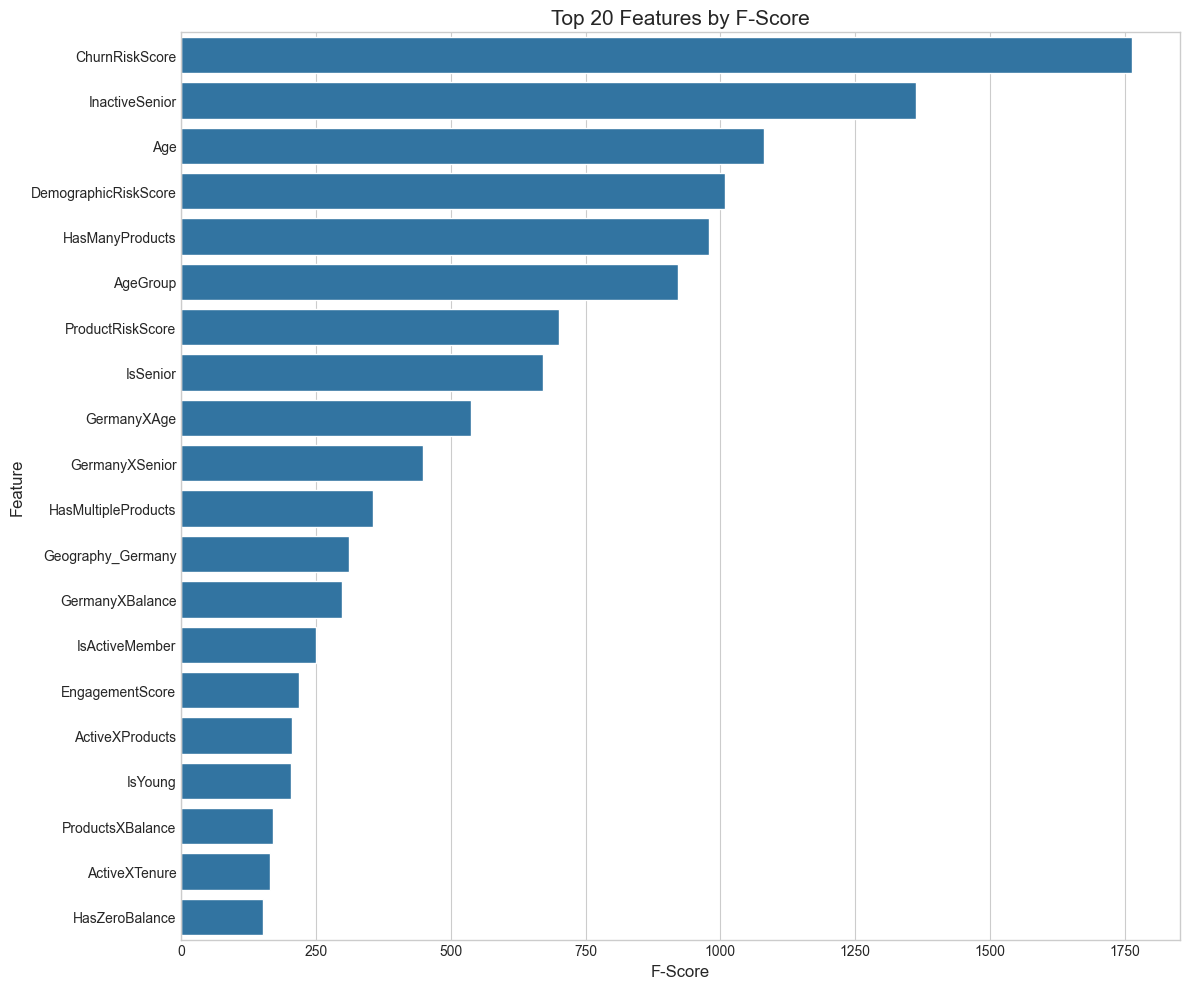

In [14]:
# Visualize F-scores
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='F_Score', y='Feature', data=f_scores.head(20))
plt.title('Top 20 Features by F-Score', fontsize=15)
plt.xlabel('F-Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../docs/plots/top_features_f_score.png', dpi=300, bbox_inches='tight')
plt.show()

### 11.2 Mutual Information Feature Selection
MI is a measure of the mutual dependence between two variables. It quantifies the amount of information obtained about one variable through the other variable.

In [15]:
# Select top features using Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=20)
selector_mi.fit(X, y)

# Get feature scores
mi_scores = pd.DataFrame({
    'Feature': all_features,
    'MI_Score': selector_mi.scores_
})

# Sort by MI-score
mi_scores = mi_scores.sort_values('MI_Score', ascending=False)

# Display top features
print("Top 20 features selected by Mutual Information:")
mi_scores.head(20)

Top 20 features selected by Mutual Information:


,Feature,MI_Score
33,EngagementScore,0.086219
38,ChurnRiskScore,0.085443
26,ProductsXAge,0.085173
4,NumOfProducts,0.071631
1,Age,0.069477
13,AgeGroup,0.061686
37,InactiveSenior,0.051105
40,ProductRiskScore,0.043898
39,DemographicRiskScore,0.043596
18,GermanyXAge,0.043201


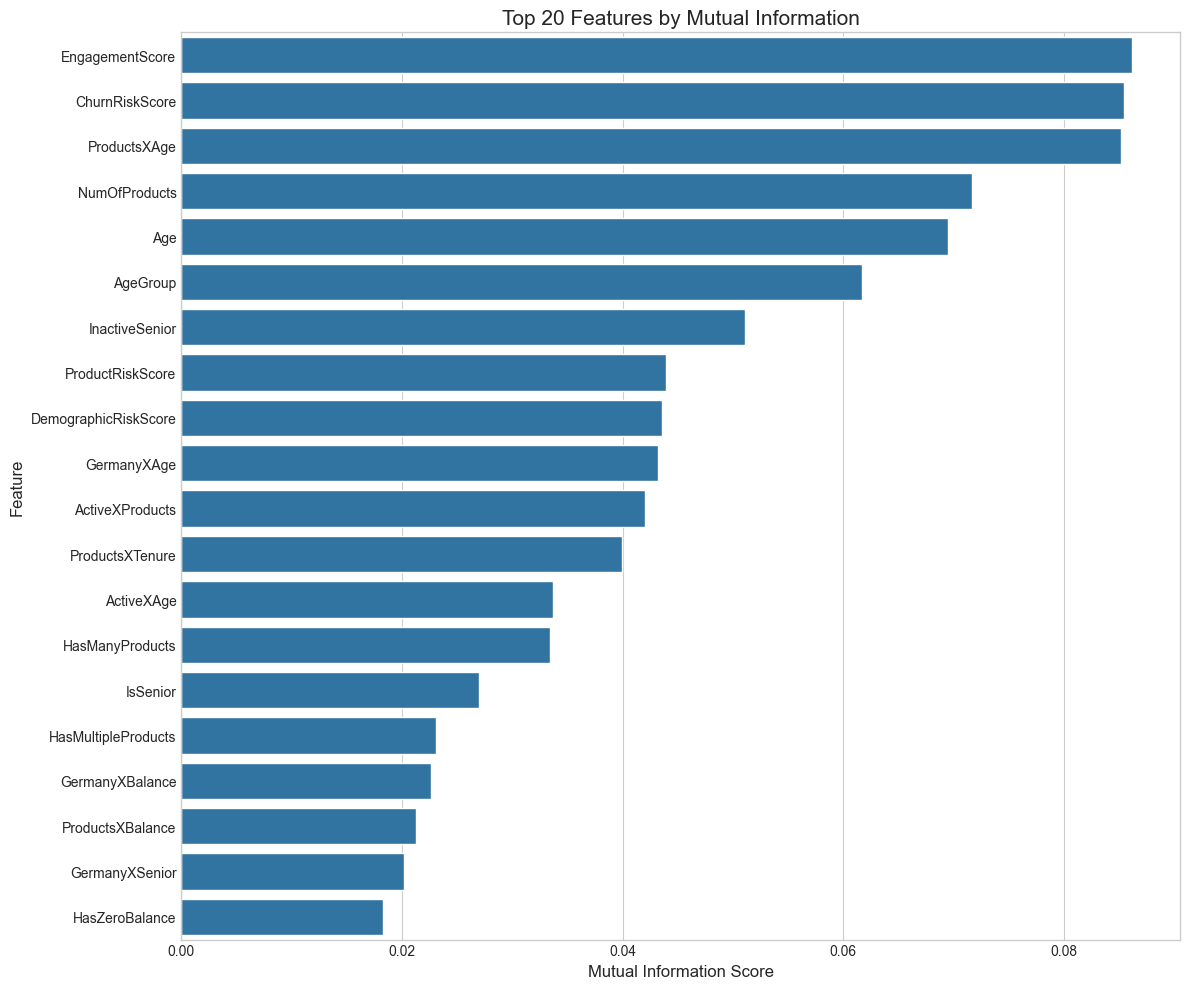

In [16]:
# Visualize MI-scores
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='MI_Score', y='Feature', data=mi_scores.head(20))
plt.title('Top 20 Features by Mutual Information', fontsize=15)
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../docs/plots/top_features_mi_score.png', dpi=300, bbox_inches='tight')
plt.show()

### 11.3 Compare Feature Selection Methods

In [17]:
# Compare top features from both methods
top_f_features = set(f_scores.head(20)['Feature'])
top_mi_features = set(mi_scores.head(20)['Feature'])

# Find common features
common_features = top_f_features.intersection(top_mi_features)
print(f"Number of common features: {len(common_features)}")
print(f"Common features: {sorted(list(common_features))}")

# Find unique features in each method
unique_f_features = top_f_features - top_mi_features
unique_mi_features = top_mi_features - top_f_features

print(f"\nFeatures unique to F-score: {sorted(list(unique_f_features))}")
print(f"Features unique to MI-score: {sorted(list(unique_mi_features))}")

Number of common features: 16
Common features: ['ActiveXProducts', 'Age', 'AgeGroup', 'ChurnRiskScore', 'DemographicRiskScore', 'EngagementScore', 'GermanyXAge', 'GermanyXBalance', 'GermanyXSenior', 'HasManyProducts', 'HasMultipleProducts', 'HasZeroBalance', 'InactiveSenior', 'IsSenior', 'ProductRiskScore', 'ProductsXBalance']

Features unique to F-score: ['ActiveXTenure', 'Geography_Germany', 'IsActiveMember', 'IsYoung']
Features unique to MI-score: ['ActiveXAge', 'NumOfProducts', 'ProductsXAge', 'ProductsXTenure']


## 12. Create Feature Sets

In [18]:
# Create different feature sets
feature_sets = {
    'all': all_features,
    'original': ['CreditScore', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 
                'Gender_Female', 'Gender_Male', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
    'f_score_top20': f_scores.head(20)['Feature'].tolist(),
    'mi_score_top20': mi_scores.head(20)['Feature'].tolist(),
    'common': list(common_features),
    'selected_top': [
        # Top features from both methods
        'Age', 'IsSenior', 'IsActiveMember', 'Geography_Germany', 'InactiveSenior',
        'ChurnRiskScore', 'DemographicRiskScore', 'ProductRiskScore',
        'HasManyProducts', 'HasMultipleProducts', 'NumOfProducts',
        'ActiveXProducts', 'GermanyXSenior', 'Balance', 'HasZeroBalance',
        # Additional features based on domain knowledge
        'Gender_Male', 'Tenure', 'IsNewCustomer', 'EngagementScore'
    ]
}

# Print feature set sizes
for name, features in feature_sets.items():
    print(f"{name}: {len(features)} features")

all: 41 features
original: 13 features
f_score_top20: 20 features
mi_score_top20: 20 features
common: 16 features
selected_top: 19 features


## 13. Save Engineered Data

In [19]:
# Save unscaled engineered data
df_engineered.to_csv('../data/processed/churn_engineered.csv', index=False)

# Save scaled engineered data
df_scaled.to_csv('../data/processed/churn_engineered_scaled.csv', index=False)

# Save feature sets to JSON
with open('../models/feature_sets.json', 'w') as f:
    json.dump(feature_sets, f, indent=4)

print("Engineered data and feature sets saved successfully.")

Engineered data and feature sets saved successfully.
